In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
conda install -c conda-forge xgboost=3.0.2 lightgbm=4.6.0 missingno=0.5.2

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [157]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
data_dir = os.path.join(os.getenv('HOME'), 'work/kaggle_kakr_housing/data')
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_path = join(data_dir, 'train.csv')
test_path = join(data_dir, 'test.csv')

print(train_path)
print(test_path)

/home/jovyan/work/kaggle_kakr_housing/data/train.csv
/home/jovyan/work/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [159]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [160]:
y = train['price']
# train.drop(columns=['price'], inplace=True)

In [161]:
train_len = len(train)
data = pd.concat([train, test], axis=0)

In [162]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

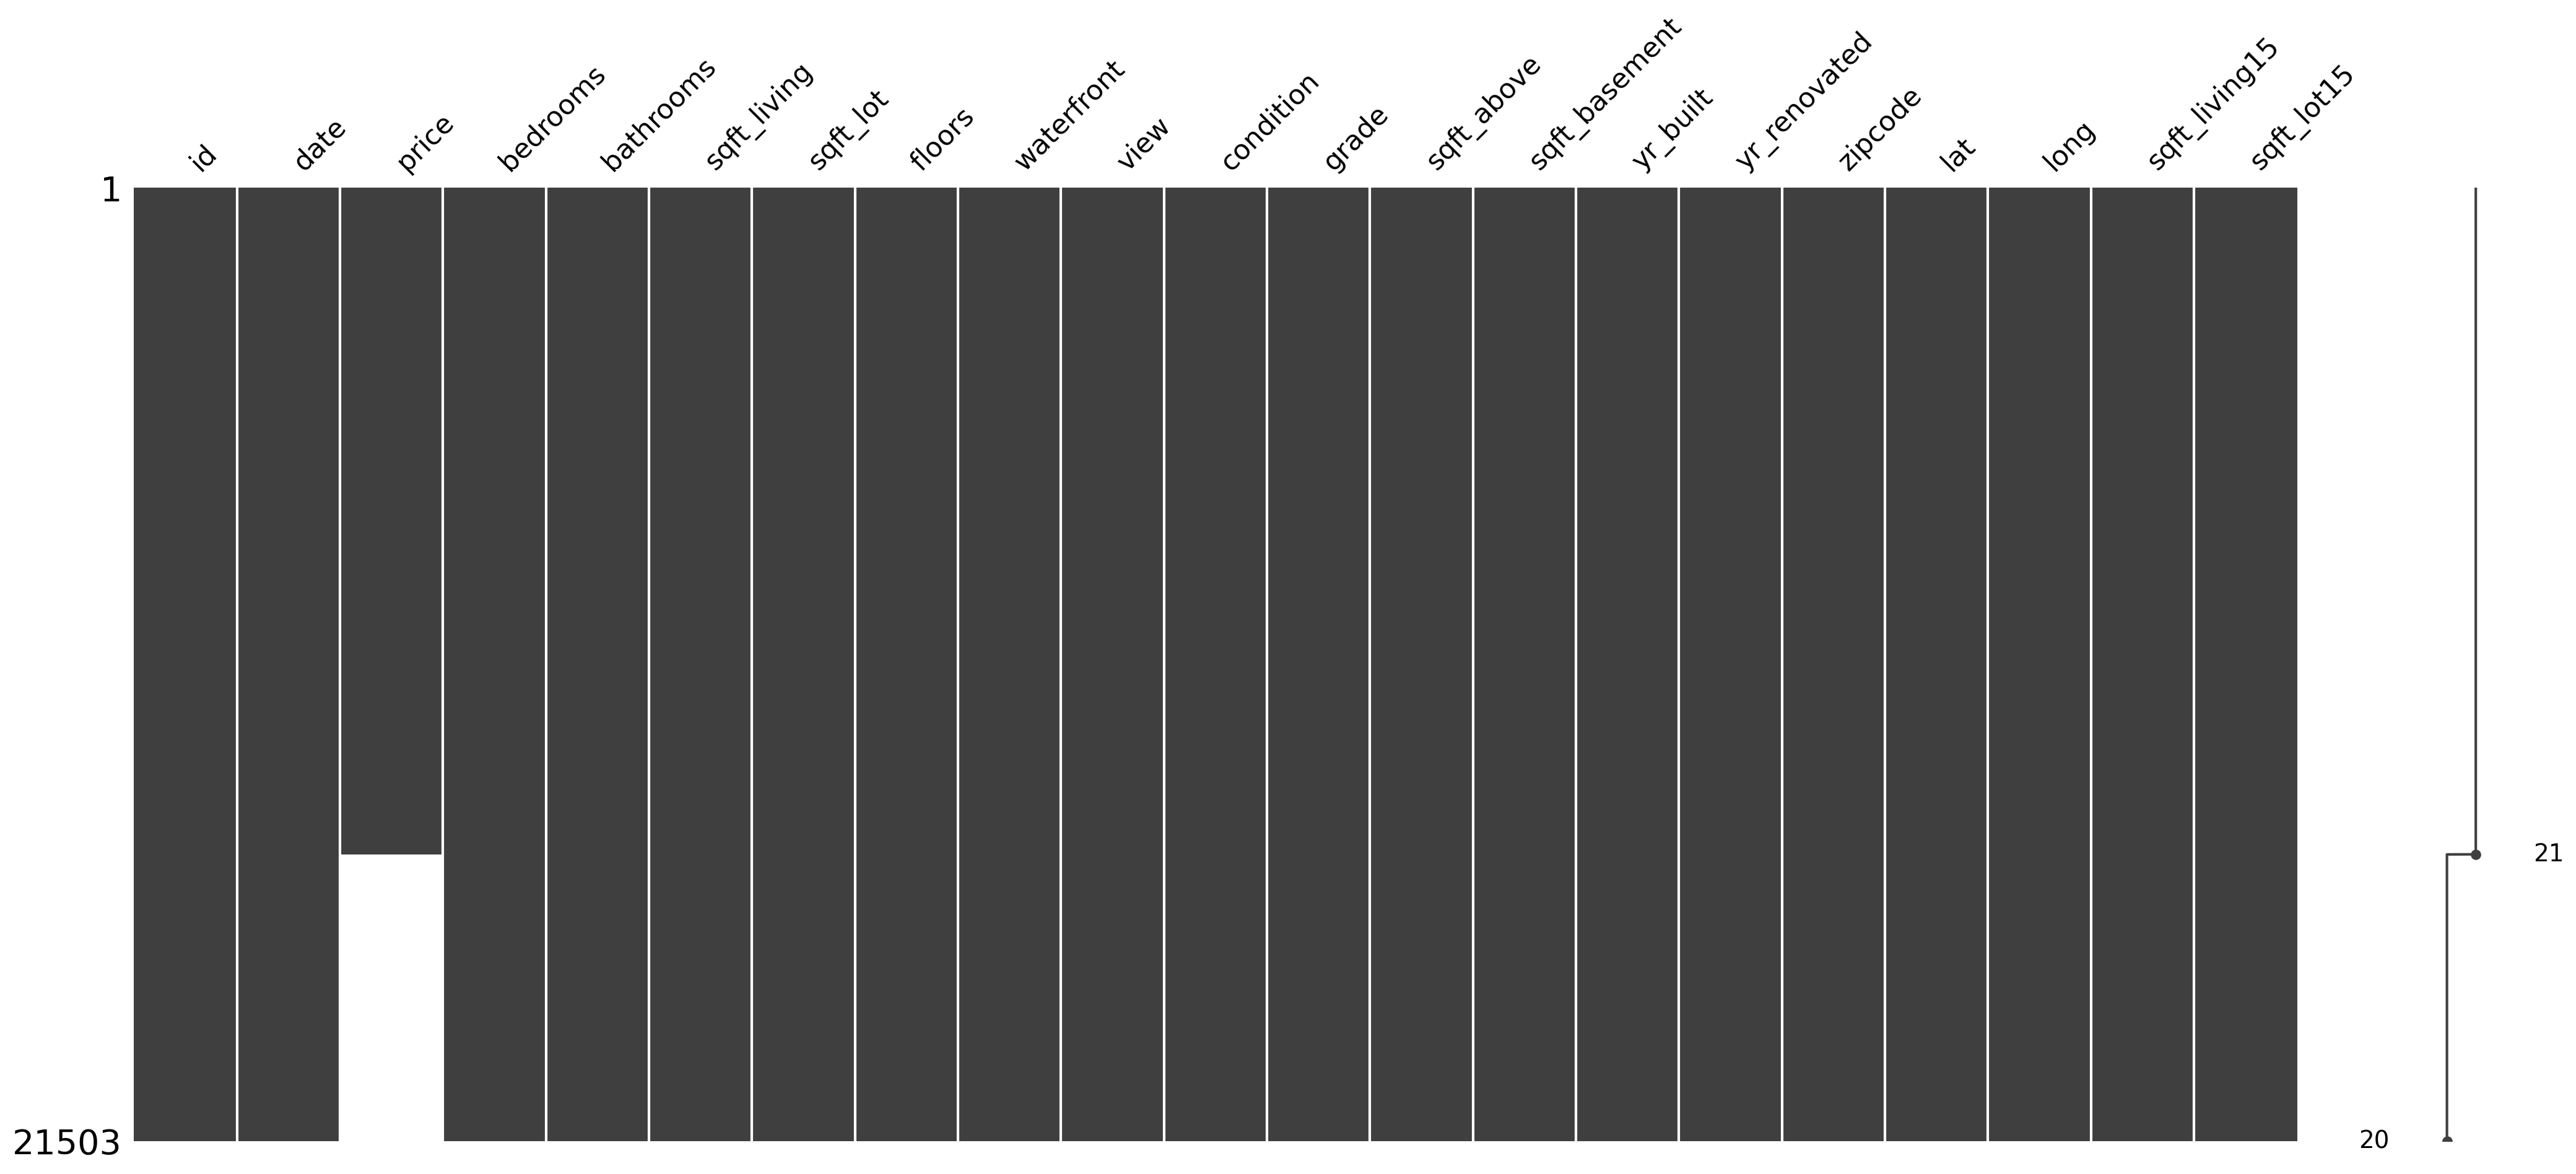

In [163]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [164]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [165]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

# 한 번에 뿅!
# 추가 : 위에 실행했던 코드는 f-string으로 작동하지만 해당 코드는 대괄호가 2개가 있어 f-string으로 표현하면 에러가 발생합니다. 이럴 경우 format으로 실행합니다.
# 추가에 대한 내용 : https://blockdmask.tistory.com/429
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool
id: 0
id : 0
id : 0
date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [166]:
# 🧼 전처리
sub_id = data['id'][train_len:]
data.drop(columns=['id'], inplace=True)
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   price          15035 non-null  float64
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_living1

In [168]:
# Feature Engineering

In [169]:
# ✅ 전처리 시작
from math import radians, cos, sin, asin, sqrt, atan2, degrees
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# 🧮 기본 파생 변수
data['house_age'] = 2025 - data['yr_built']
data.drop(columns=['yr_built'], inplace=True)

data['grade_area'] = data['grade'] * data['sqft_living']
data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['renovated_age'] = data['yr_renovated'].apply(lambda x: 2025 - x if x > 0 else 0)
data['total_rooms'] = data['bedrooms'] + data['bathrooms']
data['room_density'] = data['sqft_living'] / (data['total_rooms'] + 1)
data['house_volume'] = data['sqft_living'] * data['floors']
data['living_ratio'] = data['sqft_living'] / (data['sqft_lot'] + 1)
data['basement_ratio'] = data['sqft_basement'] / (data['sqft_living'] + 1)
data['bath_per_bed'] = data['bathrooms'] / (data['bedrooms'] + 1)
data['lat_long'] = data['lat'] * data['long']
data['luxury_score'] = data['grade'] * data['sqft_living'] * (data['view'] + 1)

# 🗓️ 날짜 → 연도 / 월
data['year'] = data['date'] // 100
data['month'] = data['date'] % 100

# 📮 우편번호 전처리
data['zipcode3'] = data['zipcode'] // 100
data.drop(columns=['zipcode'], inplace=True)

# 📍 시애틀 중심점 기준 거리 및 방향 계산
center_lat, center_long = 47.5112, -122.257

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

def bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = sin(dlon) * cos(lat2)
    y = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(dlon)
    return (degrees(atan2(x, y)) + 360) % 360

data['distance_center'] = data.apply(lambda row: haversine(row['lat'], row['long'], center_lat, center_long), axis=1)
data['bearing_center'] = data.apply(lambda row: bearing(row['lat'], row['long'], center_lat, center_long), axis=1)

# 📊 KMeans 클러스터링
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
data['kmeans_cluster'] = kmeans.fit_predict(data[['lat', 'long']])

# 🧑‍🤝‍🧑 가까운 5개 집 거리 평균
train_features = data.iloc[:train_len][['lat', 'long']]
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features)
distances, indices = nbrs.kneighbors(data[['lat', 'long']])
data['neighbor_distance_5'] = distances.mean(axis=1)

# 🔪 지역 구간화
data['lat_bin'] = pd.qcut(data['lat'], q=10, labels=False)
data['long_bin'] = pd.qcut(data['long'], q=10, labels=False)

print("✅ Feature engineering 완료")


✅ Feature engineering 완료


In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 21503 non-null  int64  
 1   price                15035 non-null  float64
 2   bedrooms             21503 non-null  int64  
 3   bathrooms            21503 non-null  float64
 4   sqft_living          21503 non-null  int64  
 5   sqft_lot             21503 non-null  int64  
 6   floors               21503 non-null  float64
 7   waterfront           21503 non-null  int64  
 8   view                 21503 non-null  int64  
 9   condition            21503 non-null  int64  
 10  grade                21503 non-null  int64  
 11  sqft_above           21503 non-null  int64  
 12  sqft_basement        21503 non-null  int64  
 13  yr_renovated         21503 non-null  int64  
 14  lat                  21503 non-null  float64
 15  long                 21503 non-null  float

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

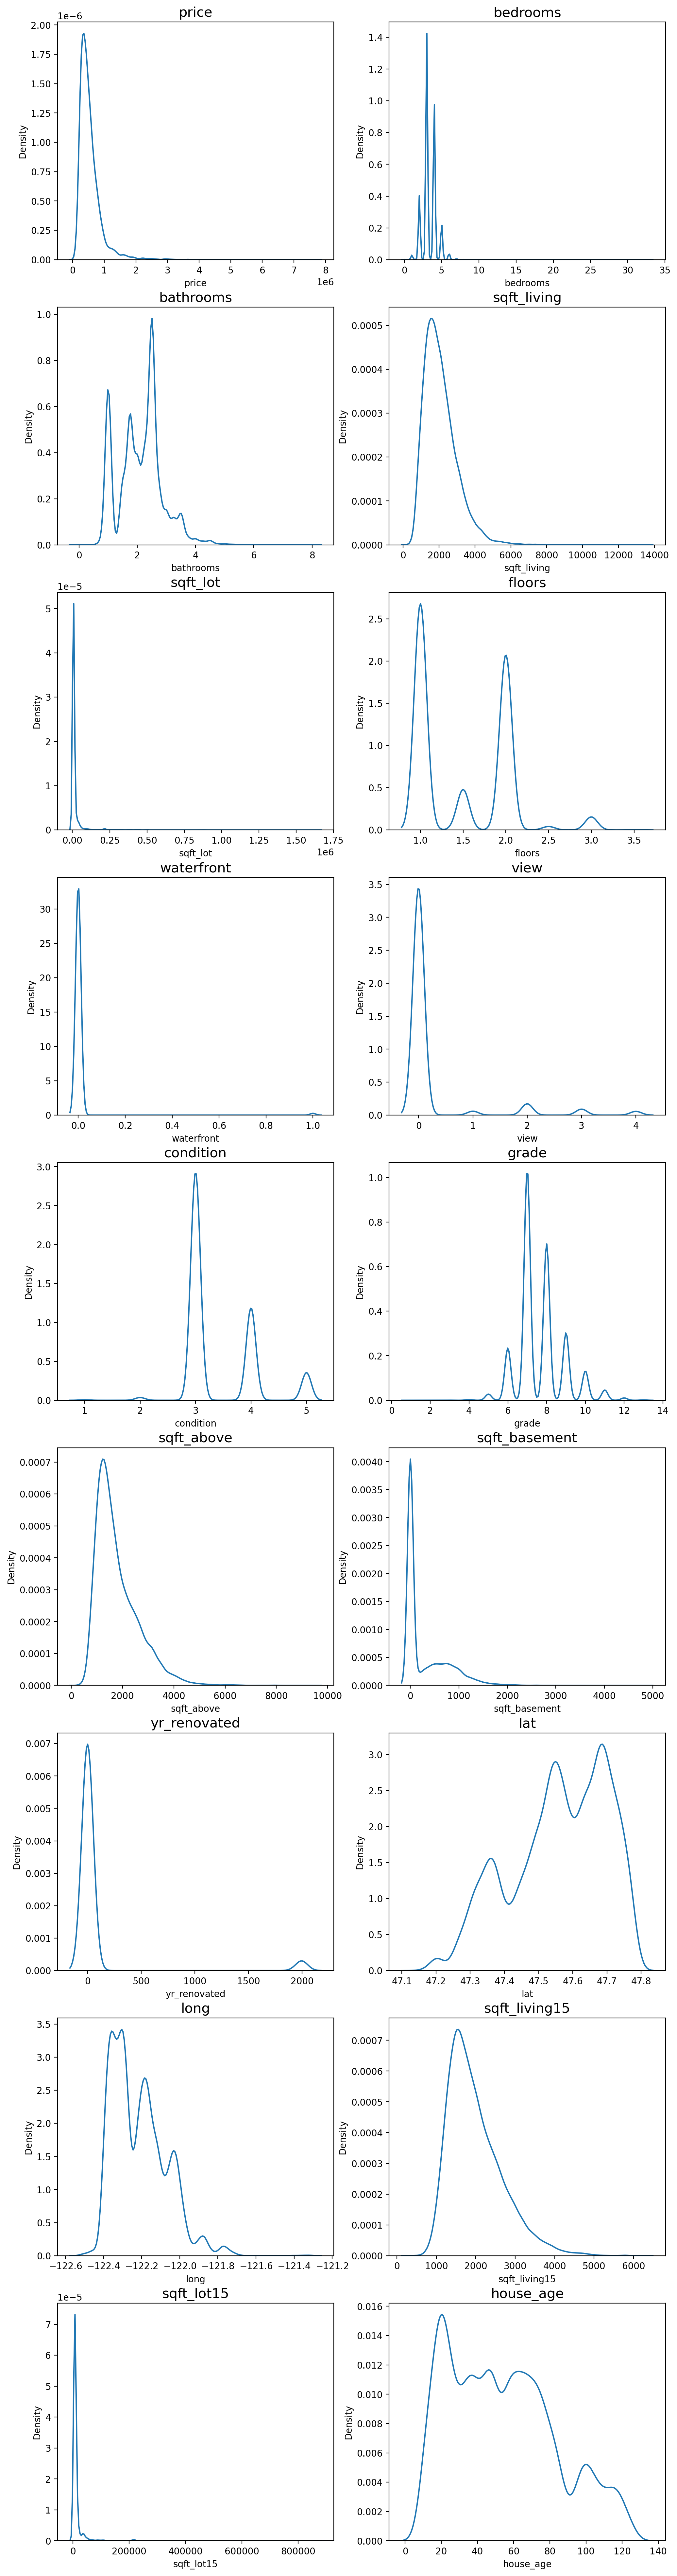

In [135]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [171]:
# 로그 변환 (왜도 보정)
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

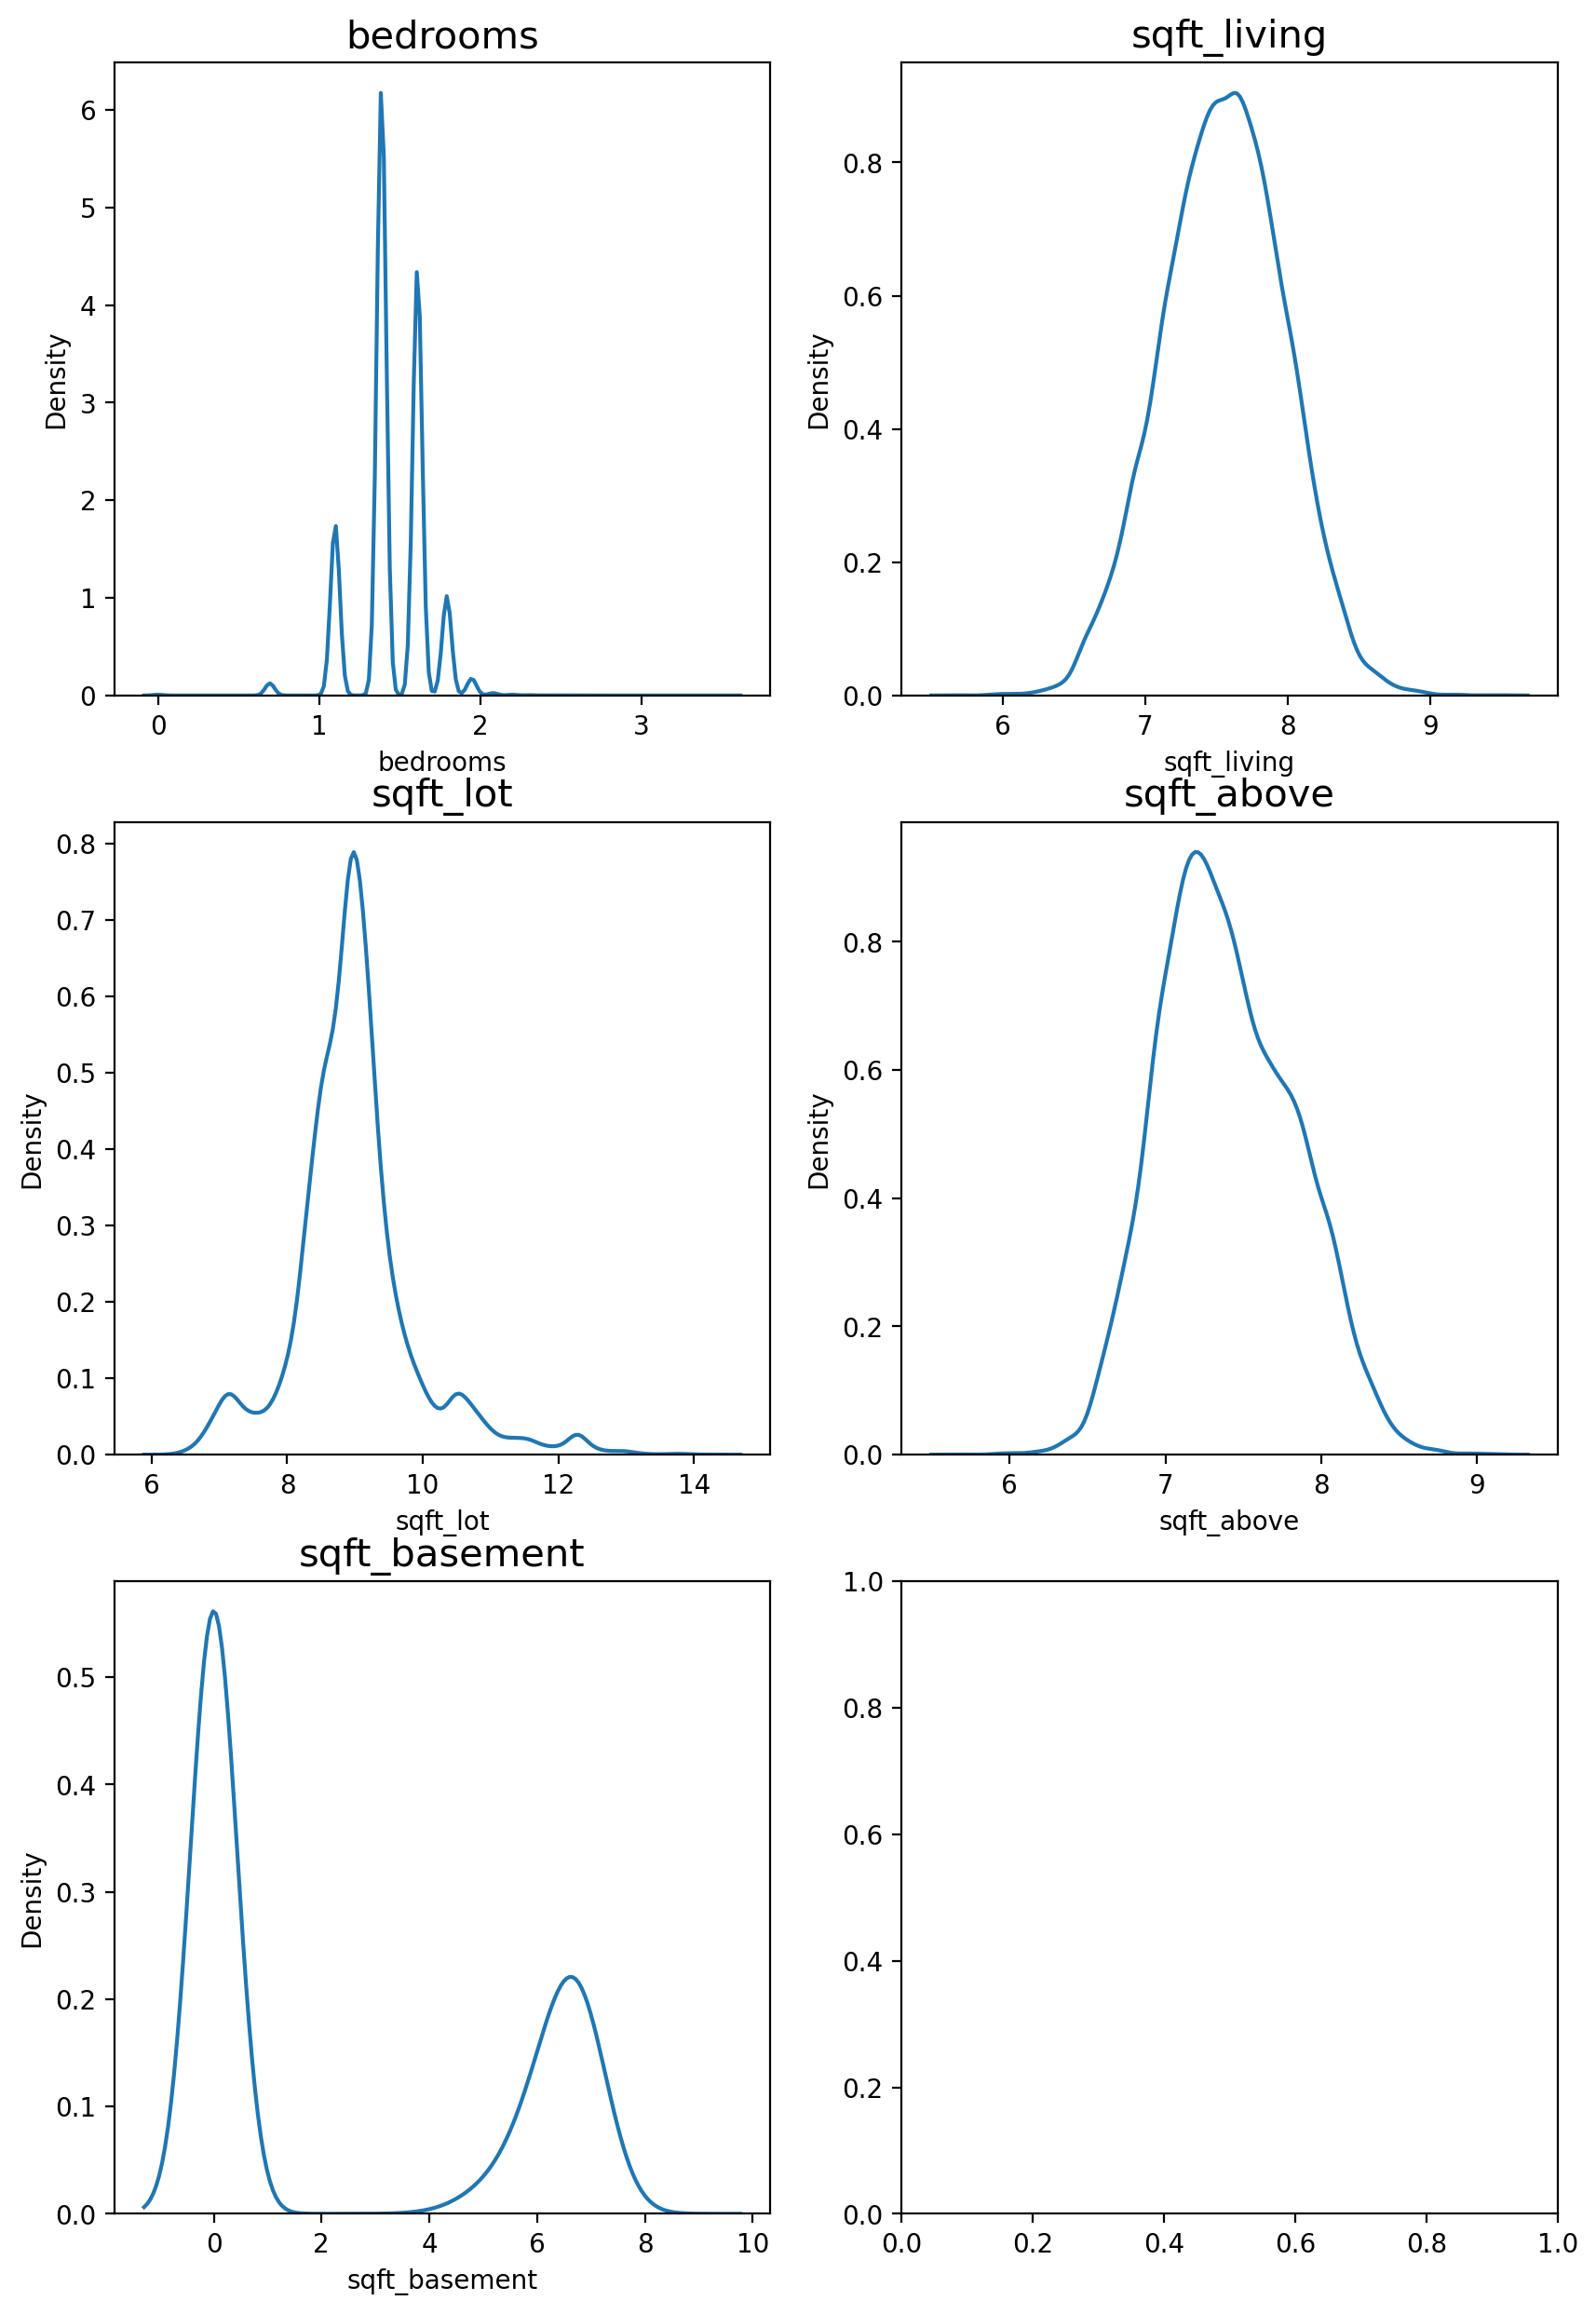

In [61]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

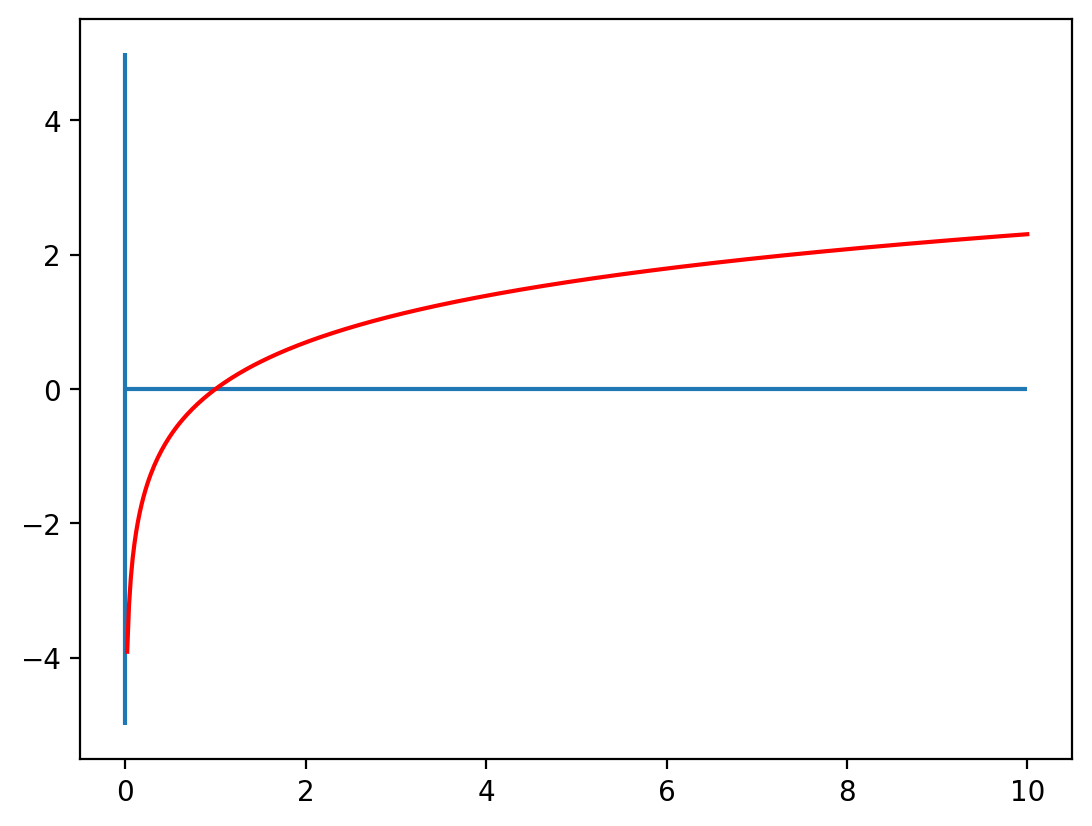

In [20]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

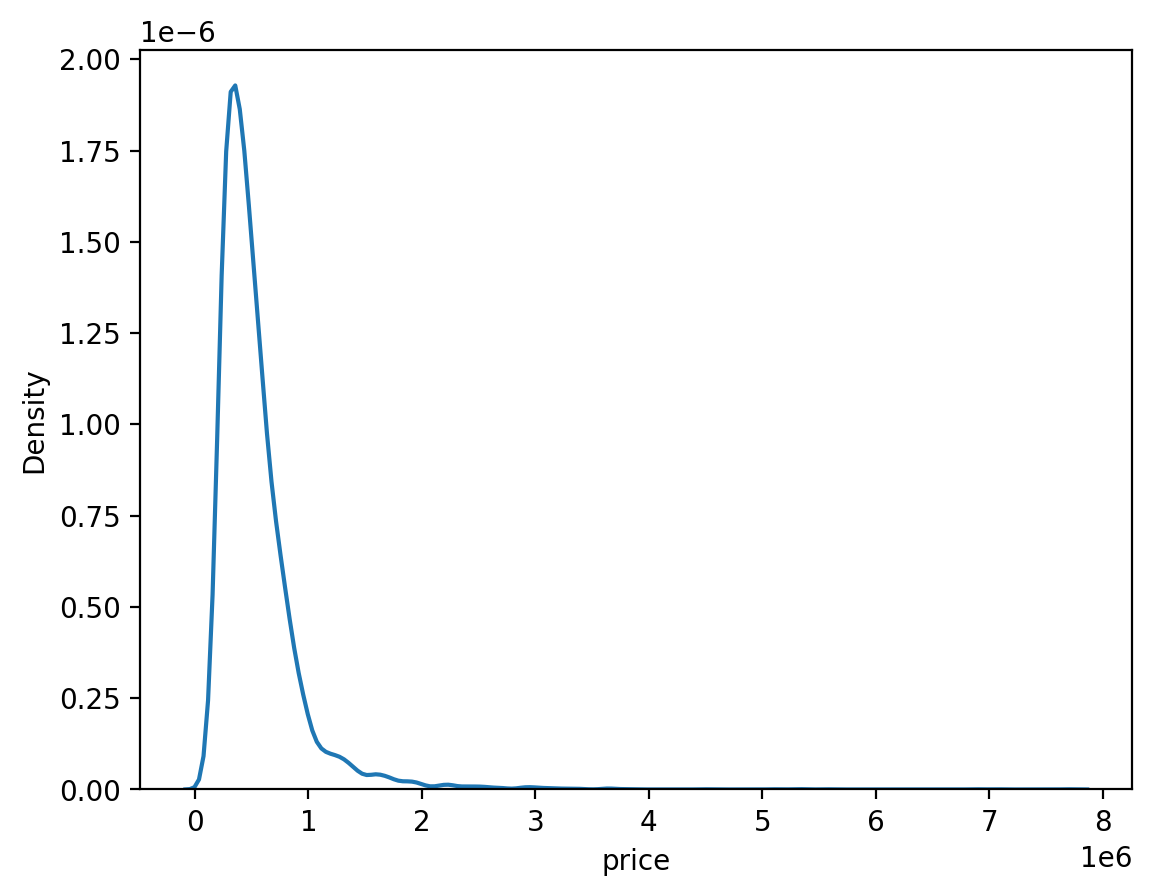

In [21]:
sns.kdeplot(y)
plt.show()

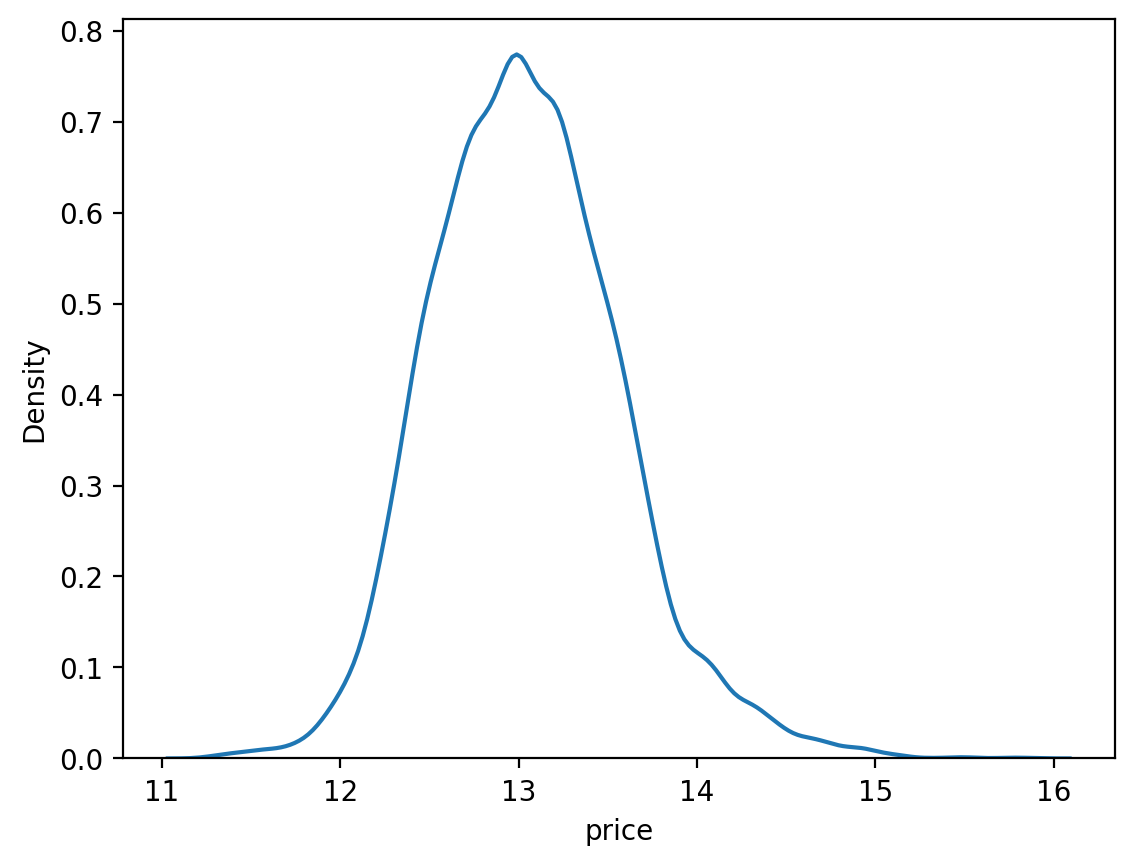

In [22]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [107]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # 🔍 ID, price, date 등 제외한 피처만 사용
# exclude_cols = ['id', 'price', 'date']  # 필요 시 추가
# feature_cols = [col for col in data.columns if col not in exclude_cols]

# # ⚖️ 스케일링
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(data[feature_cols])

# # 🧠 PCA 적용 (예: 분산 90% 보존)
# pca = PCA(n_components=0.90, random_state=42)
# X_pca = pca.fit_transform(X_scaled)

# # 🔁 train/test 재분리
# x = X_pca[:train_len]
# sub_x = X_pca[train_len:]

# print(f"PCA 이후 feature 수: {x.shape[1]}")

PCA 이후 feature 수: 14


In [172]:
# 상관계수 계산
corr_matrix = data.corr()

# 타겟 변수와의 상관관계만 추출
target_corr = corr_matrix['price'].drop('price')  # 본인 제외

# 기준 설정: 절댓값 기준 상관관계가 0.01 이하인 컬럼 제거
low_corr_features = target_corr[abs(target_corr) < 0.01].index.tolist()
print("🔍 제거할 컬럼:", low_corr_features)

# 제거
data.drop(columns=low_corr_features, inplace=True)

🔍 제거할 컬럼: ['date', 'year']


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                15035 non-null  float64
 1   bedrooms             21503 non-null  float64
 2   bathrooms            21503 non-null  float64
 3   sqft_living          21503 non-null  float64
 4   sqft_lot             21503 non-null  float64
 5   floors               21503 non-null  float64
 6   waterfront           21503 non-null  int64  
 7   view                 21503 non-null  int64  
 8   condition            21503 non-null  int64  
 9   grade                21503 non-null  int64  
 10  sqft_above           21503 non-null  float64
 11  sqft_basement        21503 non-null  float64
 12  yr_renovated         21503 non-null  int64  
 13  lat                  21503 non-null  float64
 14  long                 21503 non-null  float64
 15  sqft_living15        21503 non-null  int64

In [174]:
# 🔁 train/test 재분리
data.drop(columns=['price'], inplace=True)
x = data.iloc[:train_len, :]
sub_x = data.iloc[train_len:, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [176]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [140]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [141]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)


In [26]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8583
Model: XGBoost, CV score:0.8701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2551
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 20
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
Y

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [177]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [27]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge

# stack_model = StackingRegressor(
#     estimators=[
#         ('gb', gboost),
#         ('xgb', xgboost),
#         ('lgb', lightgbm)
#     ],
#     final_estimator=Ridge()
# )
# stack_model.fit(x, y)
# y_pred = stack_model.predict(sub_x)

In [143]:
from sklearn.model_selection import GridSearchCV

# 공통 하이퍼파라미터 탐색 함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, 
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    print(f"Best RMSLE: {results.iloc[0]['RMSLE']:.4f}")
    return grid_model.best_estimator_, results


In [178]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import pandas as pd
import numpy as np

# 파라미터가 많은 경우 랜덤하게 search 를 진행할 수 있다
def my_RandomSearch(model, train, y, param_distributions, n_iter=30, cv=5, verbose=2, n_jobs=-1, random_state=42):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv,
        verbose=verbose,
        n_jobs=n_jobs,
        random_state=random_state
    )
    search.fit(train, y)

    params = search.cv_results_['params']
    score = search.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    print(f"Best RMSLE: {results.iloc[0]['RMSLE']:.4f}")
    return search.best_estimator_, results


In [179]:
# # 🎛 파라미터 그리드
# param_grids = {
#     'GradientBoosting': {'n_estimators': [100, 256], 'max_depth': [5, 9], 'learning_rate': [0.025], 'subsample': [0.7]},
#     'XGBoost': {'n_estimators': [121, 200], 'max_depth': [5, 9], 'learning_rate': [0.06], 'subsample': [0.72]},
#     'LightGBM': {'n_estimators': [200, 346], 'max_depth': [5, 9], 'learning_rate': [0.04], 'subsample': [0.85]}
# }
param_dists = {
    'GradientBoosting': {
        'n_estimators': [100, 256],
        'max_depth': [5, 9],
        'learning_rate': [0.025],
        'subsample': [0.7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 3],
        'max_features': ['sqrt']
    },
    'XGBoost': {
        'n_estimators': [121, 200],
        'max_depth': [5, 9],
        'learning_rate': [0.06],
        'subsample': [0.72],
        'colsample_bytree': [0.7, 0.9],
        'gamma': [0, 0.1],
        'reg_alpha': [0, 0.01],
        'reg_lambda': [1, 2]
    },
    'LightGBM': {
        'n_estimators': [200, 346],
        'max_depth': [5, 9],
        'learning_rate': [0.04],
        'subsample': [0.85],
        'num_leaves': [31, 50],
        'colsample_bytree': [0.7, 0.9],
        'reg_alpha': [0.0, 0.01],
        'reg_lambda': [0.0, 1.0]
    }
}

In [ ]:
# 🧠 튜닝 실행 (RandomizedSearchCV 사용)
best_models = []

for m in models:
    name = m['name']
    print(f"\n🔍 Randomized Tuning {name}...")
    
    param_dist = param_dists[name]  # param_dists는 모델별 분포형 파라미터 딕셔너리
    best_model, _ = my_RandomSearch(
        m['model'], x, y,
        param_distributions=param_dist,
        n_iter=20,  # 시도할 조합 수
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    best_models.append({'model': best_model, 'name': name})


🔍 Randomized Tuning GradientBoosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [147]:
# # GridSearch 로 튜닝 실행
# best_models = []
# for m in models:
#     name = m['name']
#     print(f"\n🔍 Tuning {name}...")
#     best_model, _ = my_GridSearch(m['model'], x, y, param_grids[name], verbose=1, n_jobs=-1)
#     best_models.append({'model': best_model, 'name': name})

In [ ]:
# 🎯 예측
sub_x = sub_x[x.columns]  # 컬럼 정렬 맞추기
y_pred = AveragingBlending(best_models, x, y, sub_x)

In [155]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge

# # best_models 리스트에서 모델 추출
# stack_estimators = [(m['name'], m['model']) for m in best_models]

# # 스태킹 모델 정의
# stack_model = StackingRegressor(
#     estimators=stack_estimators,
#     final_estimator=Ridge()
# )

# # 학습 및 예측
# stack_model.fit(x, y)
# y_pred = stack_model.predict(sub_x)

In [ ]:
# 💾 결과 저장
submission = pd.DataFrame({'id': sub_id, 'price': y_pred})
submission.to_csv('final_submission.csv', index=False)
print("✅ 저장 완료: final_submission.csv")